# Startup


In [ ]:
#!pip install keras

## Imports and GPU Management

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

# Definition Modules
from abc import ABC, abstractmethod

# Operation Modules
import numpy as np
import tensorflow as tf
from tensorflow.python.types.core import TensorLike
from keras.layers.dense_attention import BaseDenseAttention

import math
from collections import OrderedDict
from collections.abc import Mapping
from itertools import chain

# Early Visualization Imports
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Hyperparameters


In [ ]:
#@title Global Hyperparameters
########## Ground Truth ##########
operations = {b'ring_fill'}
# operations = {b'ring_fill', b'circle_border'}
# operations = {b'has_neighbors'}
onehot_key="operation"


TARGET_CHANNELS = 1
SRC_IM_CHANNELS = 1
CATEGORY_1HOT_D = len(operations)


########## Embedding spatial information ##########
USE_ORIGINAL_XY = True
ORIGINAL_XY_CHN = 2 if USE_ORIGINAL_XY else 0

SINE_ANNOTATION = False and USE_ORIGINAL_XY
SIN_FREQUENCIES = [0.1, 1, 10]
SINE_ANNOTATE_N = 2*len(SIN_FREQUENCIES) if SINE_ANNOTATION else 0

USE_CENTER_DIST = False and USE_ORIGINAL_XY
CENTER_DIST_CHN = 1 if USE_CENTER_DIST else 0

########## Annotation Summary ##########
# The annotated image dims will be:
# [width, height, ORIGINAL_XY_CHN + TARGET_CHANNELS + SRC_IM_CHANNELS + CATEGORY_1HOT_D + SINE_ANNOTATE_N + CENTER_DIST_CHN]
SOURCE_CHANNELS = SRC_IM_CHANNELS + CATEGORY_1HOT_D + SINE_ANNOTATE_N + CENTER_DIST_CHN # Channels which will be fed as the source data to the model
PREPRO_CHANNELS = ORIGINAL_XY_CHN + TARGET_CHANNELS + SOURCE_CHANNELS                   # Total channels coming off the annotation pipeline

########## Downsampling ##########
RESIZE_FRACTION = 1

########## Patching and Batching ##########
FINAL_PATCHSIZE = 64
# Compute patch sizes such that final patches, despite rotation, are inscribed in the pre-rotated patches
INSCRIBED_PATCH = int(2*FINAL_PATCHSIZE/math.sqrt(2.0))
FINAL_BATCHSIZE = 6

########## Metric Tracking ##########
# del ca_metrics
if "ca_metrics" not in locals():
  ca_metrics = {}

In [ ]:
#@title Model Hyperparameters
########## Model Padding ##########
IMG_PADDING_NUM = 2
IMG_PADDING_MOD = "SYMMETRIC"

########## Model Iteration ##########
N_CELL_ITER_MIN = 10
N_CELL_ITER_MAX = 20
STEPMUL_DEFAULT = 1

########## Sobel and Context      ##########
CONTEXT_RADIUS  = 2
SOBEL_RADIUS    = 1

########## Simple Model Size      ##########
HIDDEN_CHANNELS = 128
CONV2D_CHANNELS = 256

########## Attention Model Size   ##########
P2Q_HIDDEN_DIMS = 32
Q_HEAD_PER_CELL = 4

## Quality-of-Life Functions

In [ ]:
def smart_repr(key, value):
    if isinstance(value, tf.Tensor) and tf.size(value) <= 10:
      print(f"{key:20s}: {value.numpy()} @ {value.shape} / {value.dtype}")
    elif isinstance(value, OrderedDict):
      for dk, dv in value.items():
        smart_repr(f"{key}[{dk}]", dv)
    else:
      print(f"{key:20s}: [value] @ {value.shape} / {value.dtype}")

def simple_sample(ds, reply=False):
  for batch in ds.take(1):
    for key, value in batch.items():
      smart_repr(key, value)
    if reply:
      return batch

In [ ]:
#@title ChannelDict
from typing import Callable, Tuple, Dict, List, Set, Iterable

class ChannelDict(OrderedDict):
  def _pack(self, to_pack:Iterable[TensorLike]) -> TensorLike:
    return tf.concat(list(to_pack), axis=-1)

  def shapes(self) -> Tuple[Set[tf.TensorShape], int]:
    total_channels=0
    get_shape = lambda t: tuple([*t.shape[:-1], None])
    shapes = set()
    for t in self.values():
      shapes.add(get_shape(t))
      total_channels += t.shape[-1]
    return shapes, total_channels

  def keychannels(self) -> 'OrderedDict[str, int]':
    return OrderedDict([(key, value.shape[-1]) for key, value in self.items()])

  def repack(self) -> 'Tuple[TensorLike, OrderedDict[str, int]]':
    repacked = self._pack(self.values())
    return repacked, self.keychannels()

  def packapply(self, fn:Callable[[TensorLike], TensorLike], keyfn:'Callable[[OrderedDict[str, int], OrderedDict[str,int]]]'=lambda x: x, *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
    repacked, keychannel_dict = self.repack()
    result = fn(repacked, *args, **kwargs)
    keychannel_updated = keyfn(keychannel_dict)
    return ChannelDict.resplit(result, keychannel_updated)
  
  def subset(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> 'ChannelDict':
    if ordered_keys is None and unordered_keys is None:
      raise ValueError("ChannelDict subset was given no keys to subset.")
    
    if ordered_keys is not None and unordered_keys is not None:
      raise ValueError("ChannelDict subset was given both ordered and unordered keys to subset - must only have one.")
    
    if ordered_keys is not None:
      return ChannelDict(**{key: self[key] for key in ordered_keys if key in self})
      # return self._pack([self[key] for key in ordered_keys if key in self])
    else:
      return ChannelDict(**{key: self[key] for key in self.keys() if ((key in unordered_keys) != invert)})
      # return self._pack([value for key, value in self.items() if key in unordered_keys])

  def partialpack(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> TensorLike:
    if ordered_keys is None and unordered_keys is None:
      raise ValueError("ChannelDict partialpack was given no keys to pack.")
    
    if ordered_keys is not None and unordered_keys is not None:
      raise ValueError("ChannelDict partialpack was given both ordered and unordered keys to pack - must only have one.")
    
    if ordered_keys is not None:
      return self._pack([self[key] for key in ordered_keys if key in self])
    else:
      return self._pack([value for key, value in self.items() if ((key in unordered_keys) != invert)])

  @staticmethod
  def resplit(packed_tensor:TensorLike, keys_channels:'OrderedDict[str, int]') -> 'ChannelDict[str, TensorLike]':
    split = ChannelDict()
    channel_idx = 0
    for key, channel_w in keys_channels.items():
      split[key] = packed_tensor[..., channel_idx:channel_idx+channel_w]
      channel_idx += channel_w
    return split

def split_data_to_x_y(data:'ChannelDict[str, TensorLike]') -> 'Tuple[ChannelDict[str, TensorLike], TensorLike]':
  return data.subset(unordered_keys={"target"}, invert=True), data["target"]

In [ ]:
def imshow_c(im):
  imc = im.shape[-1]
  if imc == 1:
    plt.imshow(im[..., 0])
  elif imc <= 3:
    plt.imshow(tf.pad(im, [(0, 0), (0, 0), (0, 3-imc)]))
  elif len(im.shape) == 2:
    plt.imshow(im)
  else:
    raise NotImplementedError("imshow_c can't show more-than-3-channel images")

I have 2 conflicting goals for the dataset pipeline.
1. Guarantee that all the spatial data I'm managing stays the same shape and undergoes the same transformations.
2. Keep all the spatial data easily separable by its origin (EG target, source, xy, etc)

Goal 1 is well solved by stacking data as channels.  
Goal 2 is well solved by separating channels into a dict of tensors, plus tools for recombination.

tf.keras.layers.RandomFlip (and similar) will augment each batch-element and each run independently, so channels have to be stacked.

One option is a pseudo-dict which stores the real data as a channeled tensor, but keeps indices for named contiguous channel groups, and will slice out multiple groups together.

Another option is a pseudo-dict which stores the real data separately by channel, but will do concat-op-split for a given op that preserves the last dimension. That's the path I've implemented with ChannelDict.


# Generating Samples

## Hyperparameters

In [ ]:
#@title RandomSample HyperParameters
########### ALL IMAGES #################
operations_l = list(operations)
SIZE_MIN,    SIZE_MAX    = 250, 500
PX_SIZE_MIN, PX_SIZE_MAX = 0.016, .032

########### RINGS ######################
NUM_RINGS = 240
# NUM_RINGS = 2

RING_MIN_R1_THICKNESS = [[0.05], [0.03]]
RING_MAX_R1_THICKNESS = [[0.075], [0.045]]

RING_BLEND_RADIUS = 0.001
RING_BLEND_RADIUS_INV = 1.0/RING_BLEND_RADIUS

## Unitized Ruling Functions

In [ ]:
@tf.function
def make_unitized_rulers(img_w_h, pixel_size):
  xy_virtual_size = tf.cast(img_w_h, tf.float32)*tf.expand_dims(tf.cast(pixel_size, tf.float32), axis=-1)
  h_ruler = tf.linspace(0.0, xy_virtual_size[0], img_w_h[0])
  v_ruler = tf.linspace(0.0, xy_virtual_size[1], img_w_h[1])
  return [h_ruler, v_ruler], xy_virtual_size

@tf.function
def make_unitized_meshgrid(img_w_h, pixel_size):
  [h_ruler, v_ruler], xy_virtual_size = make_unitized_rulers(img_w_h, pixel_size)

  H, V = tf.meshgrid(h_ruler, v_ruler)
  return tf.stack([H, V]), xy_virtual_size

## Pattern Constructors

In [ ]:
@tf.function
def ring_inner_outer(img_w_h, pixel_size):
  [h_ruler, v_ruler], xy_virtual_size = make_unitized_rulers(img_w_h, pixel_size)

  # rings_x, rings_y          = tf.random.uniform([2, NUM_RINGS], minval=[[0], [0]],            maxval=tf.expand_dims(xy_virtual_size, axis=-1))
  rings_xy = tf.random.uniform([2, NUM_RINGS], minval=[[0], [0]],            maxval=tf.expand_dims(xy_virtual_size, axis=-1))
  # rings_r1, rings_thickness = tf.random.uniform([2, NUM_RINGS], minval=RING_MIN_R1_THICKNESS, maxval=RING_MAX_R1_THICKNESS)
  rings_r1_t = tf.random.uniform([2, NUM_RINGS], minval=RING_MIN_R1_THICKNESS, maxval=RING_MAX_R1_THICKNESS)
  rings_r1 = rings_r1_t[0]
  rings_r2 = tf.reduce_sum(rings_r1_t, axis=0)


  xr = tf.abs(h_ruler[:, None] - rings_xy[0, None, :])
  yr = tf.abs(v_ruler[:, None] - rings_xy[1, None, :])
  print(xr.shape)

  rr = tf.math.sqrt(tf.math.square(xr)[None, :, :] + tf.math.square(yr)[:, None, :])
  print(rr.shape)

  k1 = rings_r1 - rr + RING_BLEND_RADIUS
  k2 = rings_r2 - rr + RING_BLEND_RADIUS
  print(k1.shape, k2.shape)

  m1 = tf.maximum(0.0, tf.minimum(1.0, k1*RING_BLEND_RADIUS_INV*0.5))
  m2 = tf.maximum(0.0, tf.minimum(1.0, k2*RING_BLEND_RADIUS_INV*0.5))
  m2 = m2-m1
  m1 = tf.reduce_max(m1, axis=-1, keepdims=True)
  m2 = tf.reduce_max(m2, axis=-1, keepdims=True)

  m2 = tf.maximum(0.0, m2-(m1*100)); print("WARNING! ring_inner_outer is TOTALLY CHEATING!")
  return m1, m2


def make_ring_fill(img_w_h, pixel_size):
  inner, outer = ring_inner_outer(img_w_h, pixel_size)
  return ChannelDict(target = inner, source=outer)

def make_circle_border(img_w_h, pixel_size):
  inner, outer = ring_inner_outer(img_w_h, pixel_size)
  return ChannelDict(target = outer, source=inner)

In [ ]:
neighbor_convolve = tf.constant([[1.0, 1.0, 1.0],
                                 [1.0, 0.0, 1.0],
                                 [1.0, 1.0, 1.0]])[:, :, None, None]/8.0

scale = 16.0

@tf.function
def make_has_neighbors(img_w_h, pixel_size):
  mini_source = tf.random.uniform(tf.concat([[1], tf.cast(tf.cast(img_w_h, tf.float32)/scale, tf.int32), [1]], axis=-1), minval=0, maxval=1)
  source = tf.image.resize(mini_source, img_w_h, preserve_aspect_ratio=True)
  target = tf.nn.conv2d(source, neighbor_convolve, [1, 1, 1, 1], 'SAME', name="has_high_neighbors")
  target = tf.nn.relu(target-0.5)*2
  print(source.shape, target.shape)
  return ChannelDict(target=target, source=source)

## Sample and Dataset sources

In [ ]:
constructor_lookup = {
    b"ring_fill": make_ring_fill,
    b"circle_border": make_circle_border,
    b"has_neighbors": make_has_neighbors
}

@tf.function
def construct_sample_around_constructor(constructor_title, constructor_fn):
    print("Constructing new sample...")
    img_w_h = tf.random.uniform((2,), minval=SIZE_MIN, maxval=SIZE_MAX, dtype=tf.int32)
    pixel_size = tf.random.uniform((), minval=PX_SIZE_MIN, maxval=PX_SIZE_MAX, dtype=tf.float32)
    operation = constructor_title

    # Construct spatial data
    spatial_data = constructor_fn(img_w_h, pixel_size)

    return OrderedDict([
                        (onehot_key, operation),
                        ("pixel_size", pixel_size),
                        ("img_w_h", img_w_h),
                        ("spatial_data", spatial_data)
    ])


@tf.function
def make_dataset_around_constructor(constructor_title, constructor_fn):
  return tf.data.Dataset.random().map(lambda d: construct_sample_around_constructor(constructor_title, constructor_fn))

@tf.function
def make_all_construction_datasets():
  return [make_dataset_around_constructor(k, constructor_lookup[k]) for k in operations_l]

@tf.function
def make_pretransformed_images_dataset():
  return tf.data.Dataset.sample_from_datasets(make_all_construction_datasets())


## Tests

(250, 240)
(500, 250, 240)
(500, 250, 240) (500, 250, 240)
WARNING! ring_inner_outer is TOTALLY CHEATING!
Observed coverage: 0.21167819


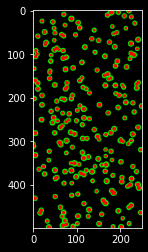

In [ ]:
ring_fill_sample = make_ring_fill([SIZE_MIN, SIZE_MAX], PX_SIZE_MIN)
ring_fill_tensor, _ = ring_fill_sample.repack()
imshow_c(ring_fill_tensor)
print("Observed coverage:", tf.reduce_sum(tf.reduce_mean(ring_fill_tensor, axis=[0, 1])).numpy())

In [ ]:
upper_bound_circle_area = np.pi * (np.sum(RING_MAX_R1_THICKNESS)**2 * NUM_RINGS)
lower_bound_image_area = (SIZE_MIN*PX_SIZE_MIN) ** 2

upper_bound_circle_fraction = upper_bound_circle_area / lower_bound_image_area
print(f"Upper bound on circle coverage:", upper_bound_circle_fraction)

Upper bound on circle coverage: 0.6785840131753953


Constructing new sample...
(None, 240)
(None, None, 240)
(None, None, 240) (None, None, 240)
WARNING! ring_inner_outer is TOTALLY CHEATING!
operation           : b'ring_fill' @ () / <dtype: 'string'>
pixel_size          : 0.029918856918811798 @ () / <dtype: 'float32'>
img_w_h             : [394 313] @ (2,) / <dtype: 'int32'>
spatial_data[target]: [value] @ (313, 394, 1) / <dtype: 'float32'>
spatial_data[source]: [value] @ (313, 394, 1) / <dtype: 'float32'>


(array([1.19971e+05, 2.90000e+01, 2.10000e+01, 2.40000e+01, 2.90000e+01,
        2.00000e+01, 1.80000e+01, 2.30000e+01, 2.10000e+01, 3.16600e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

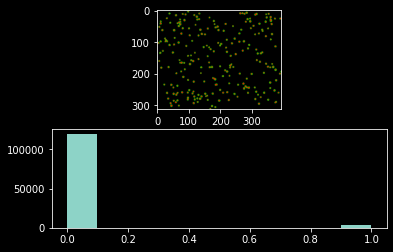

In [ ]:
ptim_ds_test = make_pretransformed_images_dataset()
ptim_sample = simple_sample(ptim_ds_test, reply=True)
ptim_sample_spatial, _ = ptim_sample["spatial_data"].repack()
fig, ax = plt.subplots(2)
ax[0].imshow(tf.pad(ptim_sample_spatial, [(0, 0), (0, 0), (0, 1)]), vmin=0, vmax=1)
ax[1].hist(tf.reshape(ptim_sample_spatial[..., 0], (-1)))

# tf.data.Dataset Pipeline

## Construct fullsize image spatial data

In [ ]:
@tf.function
def compute_original_coordinates(img_w_h, pixel_size):
  um_wh_2 = (tf.cast(img_w_h, tf.float32)*tf.expand_dims(pixel_size, axis=-1))/2.0
  h_ruler = tf.linspace(-um_wh_2[0], um_wh_2[0], img_w_h[0])
  v_ruler = tf.linspace(-um_wh_2[1], um_wh_2[1], img_w_h[1])
  XY = tf.stack(tf.meshgrid(h_ruler, v_ruler), axis=-1)

  return XY

In [ ]:
@tf.function
def compute_center_distance(XY):
  XYSquaredSum = tf.reduce_sum(tf.math.square(XY), axis=-1)
  DistFromCenter = tf.math.sqrt(
    tf.reduce_sum(
        tf.math.square(XY), 
        axis=-1,
        keepdims=True
    )
  )
  return DistFromCenter

@tf.function
def compute_sine_rulers(XY, sin_frequencies=SIN_FREQUENCIES):
  return tf.concat([0.5 + 0.5*tf.math.sin(XY * math.pi * 2 * freq) for freq in sin_frequencies], axis=-1)

In [ ]:
# @tf.function # I wish this would work as a tf.function, but somehow it can't find an object's __repr__, so I'm leaving it this way.
def compute_onehots(input, multiples, categories=operations):
  onehot = tf.cast(tf.stack([tf.equal(input, s) for s in categories], axis=-1), dtype=tf.float32)
  onehot = tf.tile(tf.reshape(onehot, [1, 1, -1]), tf.concat([multiples[..., ::-1], [1]], axis=-1))
  onehot = tf.ensure_shape(onehot, [None, None, len(categories)])
  return onehot

In [ ]:
@tf.function
def resize_spatial_data(spatial_data, img_w_h, resize_fraction=RESIZE_FRACTION, **kwargs):
  output_shapes = tf.cast(
    tf.cast(img_w_h, tf.float32) * RESIZE_FRACTION,
    tf.int32
  )
  return tf.image.resize(spatial_data, output_shapes, preserve_aspect_ratio=True)

In [ ]:
def build_spatial_data(d, onehot_key="operation", use_original_xy=USE_ORIGINAL_XY, use_center_dist=USE_CENTER_DIST, sine_annotation=SINE_ANNOTATION):
  ######### Embed Data
  spatial_d = d["spatial_data"]

  img_w_h    = d.pop("img_w_h")
  pixel_size = d.pop("pixel_size")
  onehot     = d.pop(onehot_key)

  spatial_d[onehot_key] = compute_onehots(onehot, img_w_h)
  print("Operations Shape:", spatial_d[onehot_key].shape)

  if use_original_xy:
    XY = compute_original_coordinates(img_w_h, pixel_size)
    spatial_d["XY"] = XY

    if use_center_dist:
      spatial_d["center_dist"] = compute_center_distance(XY)
    if sine_annotation:
      spatial_d["sine_annotation"] = compute_sine_rulers(XY)
  
  ########## Do Resizing
  resized_spatial_d = spatial_d.packapply(lambda t: resize_spatial_data(t, img_w_h))
  return resized_spatial_d

## Split and augment fullsize images

In [ ]:
@tf.function
def compute_patches(spatial_data, inscribed_patch=INSCRIBED_PATCH, final_patchsize=FINAL_PATCHSIZE, **kwargs):
  return tf.image.extract_patches(tf.expand_dims(spatial_data, axis=0),
                                  sizes  = [1, inscribed_patch, inscribed_patch, 1],
                                  strides= [1, final_patchsize//2, final_patchsize//2, 1],
                                  rates  = [1, 1, 1, 1],
                                  padding="VALID")

@tf.function
def compute_patch_and_batch(spatial_data, prepro_channels=PREPRO_CHANNELS, inscribed_patch=INSCRIBED_PATCH, final_patchsize=FINAL_PATCHSIZE, **kwargs):
  patches = compute_patches(spatial_data, inscribed_patch=inscribed_patch, final_patchsize=final_patchsize, **kwargs)
  batches = tf.random.shuffle(tf.reshape(patches, [-1, inscribed_patch, inscribed_patch, prepro_channels])) 
  return batches

def patch_and_batch(d, **kwargs):
  return ChannelDict(d).packapply(lambda t: compute_patch_and_batch(t, **kwargs))

In [ ]:
def augment_spatial_data(d, **kwargs):
  least_zoomed_in = -1*(1-(1/math.sqrt(2)))
  augmentation = tf.keras.Sequential([
                                    tf.keras.layers.RandomFlip(),
                                    tf.keras.layers.RandomRotation(1),
                                    tf.keras.layers.RandomZoom(
                                        (
                                            least_zoomed_in, 
                                            least_zoomed_in*3, 
                                        )
                                    ),
                                    tf.keras.layers.RandomCrop(FINAL_PATCHSIZE, FINAL_PATCHSIZE),
  ])

  return ChannelDict(d).packapply(lambda x: augmentation(x, **kwargs))

## Construct a full data pipeline

In [ ]:
def construct_dataset(training=True):
  pretransformed_images_dataset = make_pretransformed_images_dataset()
  spatial_data = pretransformed_images_dataset.map(build_spatial_data)
  patched_spatial_data = spatial_data.map(patch_and_batch).unbatch().batch(FINAL_BATCHSIZE)
  augmented_spatial_data = patched_spatial_data.map(lambda x: augment_spatial_data(x, training=training))
  return augmented_spatial_data

## Pipeline Test

In [ ]:
#@title ds_sample for Models
ds_sample = ChannelDict(next(iter(construct_dataset())))

Operations Shape: (None, None, 1)


In [ ]:
p, d = ds_sample.repack()
p.shape, d

(TensorShape([6, 64, 64, 5]),
 OrderedDict([('target', 1), ('source', 1), ('operation', 1), ('XY', 2)]))

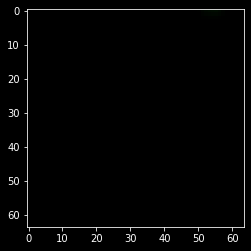

In [ ]:
imshow_c(ds_sample.partialpack(unordered_keys={"target", "source"})[0])

In [ ]:
# ds_sample.subset(ordered_keys=["source", "target", "operation", "center_dist", "sine_annotation"]).keychannels()

In [ ]:
ds_sample.subset(ordered_keys=["XY"], invert=True).keychannels()

OrderedDict([('XY', 2)])

In [ ]:
ds_sample.subset(unordered_keys=["XY"], invert=True).keychannels()

OrderedDict([('target', 1), ('source', 1), ('operation', 1)])

# How will a pixel summarize its context?
- Attention
  - [ ] Relative Positional Encoding:
    - [ ] XY
    - [ ] R-Theta
    - [ ] R
  - [ ] Queries:
    - [ ] Self
    - [ ] NN on Self and:
      - [ ] Context
      - [ ] Positional Metadata
    - [ ] Query generates relative positional encoding
    - [ ] Query generates RPE-fed attentiveness function
  - [ ] Keys:
    - [ ] Remote
    - [ ] NN on Remote and:
      - [ ] Context
      - [ ] Positional Metadata
    - [ ] Key concatenated with relative positional encoding
  - [ ] Values:
    - [ ] Remote
    - [ ] NN on Remote and:
      - [ ] Context
      - [ ] Positional Metadata
    - [ ] Value concatenated with relative positional encoding
  - [ ] Similarity Functions:
    - [ ] CosineSimilarity(Q, K) = CS
    - [ ] SC * (learned   RPE-based NN) = lRPA-CS
    - [ ] SC * (generated RPE-based NN) = gRPA-CS
- [ ] Multi-Scalar Communication
  - [ ] Several Dilated Contexts
  - [x] Larger Contexts
- GLOM regional-layeral
  - I'm not feeling the pull to fill this out.

# Can the images be presented in a better way?
- NERF-per-image
  - Selective Encoding
  - Integrate an attention query

# Model Construction

## Convenience Functions

In [ ]:
ds_sample = ChannelDict(next(iter(construct_dataset())))

Operations Shape: (None, None, 1)


In [ ]:
# #@title Generate Sobel Kernel
@tf.function
def generate_sobel(sobel_size):
  sub_half_size = (sobel_size-1)/2
  range = tf.range(-sub_half_size, sub_half_size+1, dtype=tf.float32)
  pxy = tf.stack(tf.meshgrid(range, range), axis=-1)
  dxy = tf.reduce_sum(tf.square(pxy), axis=-1)

  sobel = tf.math.divide_no_nan(pxy, dxy[..., None], name="sobel_filter")
  sobel = 2*sobel / (sobel_size**2-1) # Normalize so that a slope of 1 per pixel gives a total value of 1
  return sobel

In [ ]:
# #@title Generate Context Kernel
@tf.function
def generate_context(k_size):
  k_area = k_size**2
  indices = tf.reshape(tf.repeat(tf.range(k_area), 2), (-1, 2))
  context_kernel = tf.reshape(tf.scatter_nd(indices, tf.ones(k_area), [k_area, k_area]), [k_size,k_size,k_area], name="Context_Kernel")
  return context_kernel

In [ ]:
# #@title Construct Percept Kernel
@tf.function
def construct_percept_kernel(context_radius, sobel_radius):
    context_size = context_radius*2 + 1
    sobel_size = sobel_radius*2+1

    context = generate_context(context_size)
    sobel   = generate_sobel(sobel_size)


    diff = context_radius - sobel_radius
    sobel_pad   = tf.maximum(0, diff)
    context_pad = tf.maximum(0, -diff)

    sobel   = tf.pad(sobel,   [(sobel_pad, sobel_pad),     (sobel_pad, sobel_pad), (0, 0)])
    context = tf.pad(context, [(context_pad, context_pad), (context_pad, context_pad), (0, 0)])

    kernel = tf.concat([sobel, context], axis=-1)
    return kernel

## Class Definitions

### Abstract Classes

In [ ]:
#@title AbstractCAModel
class AbstractCAModel(ABC, tf.keras.Model):
  def __init__(self,  
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD):
    super().__init__()
    
    self.target_channels = target_channels
    self.hidden_channels = hidden_channels
    self.update_channels = target_channels + hidden_channels

    self.n_cell_iter_min = n_cell_iter_min
    self.n_cell_iter_max = n_cell_iter_max
    self.stepmul_default = stepmul_default

    self.img_padding_num = img_padding_num
    self.img_padding_mod = img_padding_mod

  @abstractmethod
  def compute_update(self, x:'ChannelDict[str, TensorLike]', iter:int=None, *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
    """Must produce a ChannelDict with keys ["y_pred_dt", "hidden_dt"] and valid-shaped tensor values"""
    pass

  @tf.function
  def pad(self, im):
    return tf.pad(im, 
                  [(0, 0), 
                   (self.img_padding_num, self.img_padding_num), 
                   (self.img_padding_num, self.img_padding_num), 
                   (0, 0)
                  ], mode=self.img_padding_mod)

  # @tf.function
  def initialize_model_state(self, padded_input):
    return padded_input.packapply(lambda t: tf.pad(t, 
                                                   [(0, 0), 
                                                    (0, 0), 
                                                    (0, 0), 
                                                    (self.target_channels, self.hidden_channels)
                                                   ], mode="CONSTANT"),
                                  keyfn = lambda keydict: OrderedDict(y_pred=self.target_channels, **keydict, hidden=self.hidden_channels)
                                  )
  
  @tf.function
  def unpad(self, im):
    # Undo padding step
    return im[:, self.img_padding_num:-self.img_padding_num, self.img_padding_num:-self.img_padding_num]

  @tf.function
  def construct_next_input(self, y_pred, source, hidden):
    return tf.concat([y_pred, source, hidden], axis=-1)

  # @tf.function
  def call(self, input:ChannelDict) -> TensorLike:
    # Padding the coordinates seems bad
    padded_input_and_coordinates = input.packapply(self.pad)
    model_state = self.initialize_model_state(padded_input_and_coordinates)
    
    iter_n = tf.random.uniform([], self.n_cell_iter_min, self.n_cell_iter_max, tf.int32)

    for i in tf.range(iter_n):
      model_update = self.compute_update(model_state, iter=i).packapply(lambda t: tf.multiply(t, self.stepmul_default, name="model_update_weighted"))
      model_state["y_pred"] += model_update["y_pred_dt"]
      model_state["hidden"] += model_update["hidden_dt"]
    return self.unpad(model_state["y_pred"])

  @tf.function
  def per_cell_mse(self, y, y_pred):
    # This function is NOT tied into the operation of this model, though it qualifies as a metric.
    squared_diff = tf.math.squared_difference(y, y_pred)
    return tf.reduce_mean(squared_diff, axis=-1)

In [ ]:
# #@title TestingCAModel
# class TestingCAModel(AbstractCAModel):
#   def compute_update(self, x:'ChannelDict[str, TensorLike]', *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
#     # print("CU x type:", type(x))
#     yh = x.subset(unordered_keys={"y_pred", "hidden"})
#     yh_dt = yh.packapply(lambda x: x, keyfn=lambda keychannel_dict: ChannelDict(**{k+"_dt":v for k, v in keychannel_dict.items()}))
#     # print("yh_dt keys:", yh_dt.keys()) 
#     return yh_dt

# testCA = TestingCAModel()
# ds_input = ds_sample.subset(unordered_keys={"input"}, invert=True)

# testCA(ds_input).shape

In [ ]:
#@title PerceptiveCAModel Abstract Class
class PerceptiveCAModel(AbstractCAModel):
  def __init__(self,
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD,
               context_radius =1,
               sobel_radius   =1
    ):
    super().__init__(target_channels,
                     hidden_channels,
                     n_cell_iter_min,
                     n_cell_iter_max,
                     stepmul_default,
                     img_padding_num,
                     img_padding_mod)
    
    self.context_radius = context_radius
    self.sobel_radius   = sobel_radius

  
  # @tf.function
  # def perceive(self, model_state):
  #   """Produce a ChannelDict that holds the local perception for each cell"""
  #   model_subset = model_state.subset(unordered_keys={"XY"}, invert=True)

  #   kernel = construct_percept_kernel(self.context_radius, self.sobel_radius)
  #   print(kernel)
  #   kernel = tf.repeat(kernel[:, :, None, :], model_subset.shapes()[1], axis=2, name="kernel")

  #   tensor_function = lambda t: tf.nn.depthwise_conv2d(t, kernel, [1, 1, 1, 1], 'SAME', name="perceive_conv2d")
  #   key_function    = lambda keydict: OrderedDict(chain.from_iterable(
  #                                                  [(f"{k}_sobel", v*2), (f"{k}_local", v*kernel.shape[-1]-2)]
  #                                                  for k, v in keydict.items()
  #                                                 ))

  #   print(key_function(model_subset.keychannels()))

  #   return model_subset.packapply(tensor_function, keyfn=key_function)

  @tf.function
  def perceive(self, model_state):
    model_subset = model_state.subset(unordered_keys={"XY"}, invert=True)
    model_pack,_ = model_subset.repack()

    kernel = construct_percept_kernel(self.context_radius, self.sobel_radius)
    kernel = tf.repeat(kernel[:, :, None, :], model_pack.shape[-1], axis=2, name="kernel")

    return tf.nn.depthwise_conv2d(model_pack, kernel, [1, 1, 1, 1], 'SAME', name="perceive_conv2d")

In [ ]:
#@title TestingPerceptiveCAModel
class TestingPerceptiveCAModel(PerceptiveCAModel):
  def compute_update(self, x:'ChannelDict[str, TensorLike]', *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
    percept = self.perceive(x)
    # print("Perception Shape:", percept.shape)
    # print("Perception Shapes and KeyChannels:", percept.shapes(), percept.keychannels())
    yh = x.subset(unordered_keys={"y_pred", "hidden"})
    yh_dt = yh.packapply(lambda x: x, keyfn=lambda keychannel_dict: ChannelDict(**{k+"_dt":v for k, v in keychannel_dict.items()}))
    # print("yh_dt keys:", yh_dt.keys()) 
    return yh_dt

testPCA = TestingPerceptiveCAModel()
ds_input = ds_sample.subset(unordered_keys={"input"}, invert=True)

testPCA(ds_input).shape

TensorShape([6, 64, 64, 1])

In [ ]:
#@title AbstractAttentionCAModel
class AbstractAttentionCAModel(PerceptiveCAModel):
  # def __init__(self, 
  #              target_channels=TARGET_CHANNELS,
  #              hidden_channels=HIDDEN_CHANNELS,
  #              n_cell_iter_min=N_CELL_ITER_MIN,
  #              n_cell_iter_max=N_CELL_ITER_MAX,
  #              stepmul_default=STEPMUL_DEFAULT,
  #              img_padding_num=IMG_PADDING_NUM,
  #              img_padding_mod=IMG_PADDING_MOD,
  #              context_radius =1,
  #              sobel_radius   =1):
  #   super().__init__(target_channels,
  #                    hidden_channels,
  #                    n_cell_iter_min,
  #                    n_cell_iter_max,
  #                    stepmul_default,
  #                    img_padding_num,
  #                    img_padding_mod,
  #                    context_radius,
  #                    sobel_radius)


  @abstractmethod
  def compute_attention_queries(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args, 
                        **kwargs) -> TensorLike:
    pass
  
  def compute_attention_keys(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args, 
                        **kwargs) -> TensorLike:
    return None

  def compute_attention_values(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args, 
                        **kwargs) -> TensorLike:
    return None
  
  @abstractmethod
  def compute_attention(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        queries:TensorLike, 
                        *args,
                        keys:TensorLike=None, 
                        values:TensorLike=None, 
                        **kwargs) -> Tuple[TensorLike, TensorLike]:
    """This function MUST return the attended results and the attention weights."""
    pass
  
  @abstractmethod
  def compute_attention_update(self,
                        model_state:'ChannelDict[str, TensorLike]',
                        attended:TensorLike,
                        *args,
                        attention_weights:TensorLike = None,
                        **kwargs) -> 'ChannelDict[str, TensorLike]':
    pass
  

  #####################################################

  def compute_update(self,
                        model_state:'ChannelDict[str, TensorLike]',
                        *args,
                        iter=0,
                        return_attention_scores=False,
                        **kwargs) -> 'ChannelDict[str, TensorLike]':
    
    decayed_iter = 1.0/(2.0**tf.cast(iter, tf.float32))
    perception = self.perceive(model_state.subset(unordered_keys={"XY"}, invert=True))

    queries = self.compute_attention_queries(model_state, d_iter=decayed_iter, perception=perception)
    keys    = self.compute_attention_keys(   model_state, d_iter=decayed_iter, perception=perception)
    values  = self.compute_attention_values( model_state, d_iter=decayed_iter, perception=perception)

    attended, attention_weights = self.compute_attention(model_state, 
                                                         queries=queries, keys=keys, values=values,
                                                         d_iter=decayed_iter)
    
    update_dict = self.compute_attention_update(model_state,
                                                attended=attended, attention_weights=attention_weights,
                                                d_iter=decayed_iter,
                                                perception=perception)

    if return_attention_scores:
      return update_dict, attention_weights
    else:
      return update_dict

### Model Implementations

#### SimpleCAModel

In [ ]:
#@title SimpleCAModel
class SimpleCAModel(PerceptiveCAModel):

  def __init__(self, 
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD,
               context_radius =CONTEXT_RADIUS,
               sobel_radius   =SOBEL_RADIUS,
               conv2d_channels=CONV2D_CHANNELS):
    super().__init__(target_channels,
                     hidden_channels,
                     n_cell_iter_min,
                     n_cell_iter_max,
                     stepmul_default,
                     img_padding_num,
                     img_padding_mod,
                     context_radius,
                     sobel_radius)
    
    self.conv2d_channels = conv2d_channels

    self.dmodel = tf.keras.Sequential([
                                       
          tf.keras.layers.Conv2D(self.conv2d_channels, 1, activation=tf.nn.tanh,
              kernel_initializer=tf.random_uniform_initializer(
                  # minval=1e-2,maxval=1e-1
                  # minval=-1*per_layer_factor, 
                  # maxval=per_layer_factor
              ),
              bias_initializer=tf.zeros_initializer
          ),

          tf.keras.layers.Conv2D(self.conv2d_channels, 1, activation=tf.nn.tanh,
              kernel_initializer=tf.random_uniform_initializer(
                  # minval=1e-2,maxval=1e-1
                  # minval=-1*per_layer_factor, 
                  # maxval=per_layer_factor
              ),
              bias_initializer=tf.zeros_initializer
          ),

          tf.keras.layers.Conv2D(self.update_channels, 1, activation=None,
              # kernel_initializer=tf.zeros_initializer),
              kernel_initializer=tf.random_uniform_initializer(
                  # minval=1e-2,maxval=1e-1
                  # minval=-1*per_layer_factor, 
                  # maxval=per_layer_factor
              ),
              bias_initializer=tf.zeros_initializer
          )
    ],
    name="CA_Sequential_Conv2D")

  # @tf.function
  def compute_update(self, x:'ChannelDict[str, TensorLike]', *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
    # XY = x["XY"]
    # inputs = x.subset(unordered_keys={"XY"}, invert=True)
    # inputs, _ = inputs.repack()

    local = self.perceive(x)
    packed_update = tf.identity(self.dmodel(local), name="yhat_update")

    update_dict = ChannelDict.resplit(packed_update, OrderedDict([("y_pred_dt", self.target_channels),
                                                                  ("hidden_dt", self.hidden_channels)]))

    return update_dict

#### DirectSelfAttentionCAModel

In [ ]:
#@title DirectSelfAttentionCAModel
class DirectSelfAttentionCAModel(AbstractAttentionCAModel): 
  def __init__(self, 
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD,
               context_radius =1,
               sobel_radius   =1):
    super().__init__(target_channels,
                     hidden_channels,
                     n_cell_iter_min,
                     n_cell_iter_max,
                     stepmul_default,
                     img_padding_num,
                     img_padding_mod,
                     context_radius,
                     sobel_radius)
    
    print(f"WARNING: {self.__class__.__name__} is using global assumptions about channels. PLEASE refactor ALL uses of `self.input_channels` into the build() step.")
    self.attention_layer = tf.keras.layers.Attention()
    self.input_channels = self.target_channels + SOURCE_CHANNELS + self.hidden_channels
    self.update_dense = tf.keras.Sequential([
                                             tf.keras.layers.Dense(self.input_channels*2, activation='tanh'),
                                             tf.keras.layers.Dense(self.update_channels, activation='tanh')])


  @tf.function
  def compute_attention_queries(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args, **kwargs) -> TensorLike:
    return model_state.subset(unordered_keys={"XY"}, invert=True)
  
  def compute_attention(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        queries:TensorLike, 
                        keys:TensorLike=None, 
                        values:TensorLike=None, 
                        *args, **kwargs) -> Tuple[TensorLike, TensorLike]:
    """This function MUST return the attended results and the attention weights."""

    qkv, _ = queries.repack()
    qkv_flat = tf.reshape(qkv, [-1, qkv.shape[1]**2, qkv.shape[-1]])
    attended, attention_weights = self.attention_layer([qkv_flat, qkv_flat], return_attention_scores=True)

    attended = tf.reshape(attended, qkv.shape)
    attention_weights = tf.reshape(attention_weights, [-1, *qkv.shape[1:3], *qkv.shape[1:3], 1])

    return attended, attention_weights

  
  def compute_attention_update(self,
                        model_state:'ChannelDict[str, TensorLike]',
                        attended:TensorLike,
                        attention_weights:TensorLike = None,
                        d_iter=0,
                        *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
    attended_and_iter = tf.concat([attended, tf.fill([*attended.shape[:-1], 1], d_iter)], axis=-1)
    packed_update = self.update_dense(attended_and_iter)

    update_dict = ChannelDict.resplit(packed_update, OrderedDict([("y_pred_dt", self.target_channels),
                                                                  ("hidden_dt", self.hidden_channels)]))
    return update_dict

##### DirectSelfAttention
1. Input
  - XY
  - CellData
    - yhat
    - source
    - 1hot
    - center distance
    - sine rulers [0.1, 1, 10]
2. Attention
  - Q: CellData
  - K: CellData
  - V: CellData
  - W: Cosine
3. 2-Layer Dense
  - From Attended Cells
  - To update (dyh/dt)

#### Performance
- v1
  - HyperParameters:
    - Final Size: 32
    - Batch Size: 3
    - Iter m/m: 10, 20
    - Stepmul Default: 1
    - Hidden Channels: 32
    - Hidden Dense: 2*input
  - Performance:
    - Dismal. Unable to respond selectively to different input channels, as expected.
    - Update: Did not set activation functions on 2-Layer Dense.
- v2
  - HyperParameters:
    - 2-Layer Dense
      - Activation: ReLU
  - Performance:
    - Exploded to NANs, just like IndirectSelfAttention (testing is currently out of sequence). Re-starting IPy Kernel.
    - Restarted, not (immediately) exploding to NANs.
    - Output still attends heavily to sine rulers.
- v3
  - Introducing a 'runtime cell channel' which is just 1/2^iter
  - Performance:
    - The model is better at approximating the average value of the target, but does not do better at anything else.

#### IndirectSelfAttentionCAModel

In [ ]:
#@title IndirectSelfAttentionCAModel
class IndirectSelfAttentionCAModel(AbstractAttentionCAModel): 
  def __init__(self,
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD,
    ):
    super().__init__(target_channels,
                     hidden_channels,
                     n_cell_iter_min,
                     n_cell_iter_max,
                     stepmul_default,
                     img_padding_num,
                     img_padding_mod)
    
    print(f"WARNING: {self.__class__.__name__} is using global assumptions about channels. PLEASE refactor ALL uses of `self.input_channels` into the build() step.")
    self.input_channels = self.target_channels + SOURCE_CHANNELS + self.hidden_channels
    
    self.query_dense = tf.keras.Sequential([
                                            tf.keras.layers.Dense(self.input_channels*2, activation="relu"),
                                            tf.keras.layers.Dense(self.input_channels)])
    
    self.attention_layer = tf.keras.layers.Attention()
    
    self.update_dense = tf.keras.Sequential([
                                             tf.keras.layers.Dense(self.input_channels*2, activation="relu"),
                                             tf.keras.layers.Dense(self.update_channels)])


  def compute_attention_queries(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args,
                        d_iter=0,
                        **kwargs) -> TensorLike:
    cells = model_state.partialpack(unordered_keys={"XY"}, invert=True)
    cells_and_iter = tf.concat([cells, tf.fill([*cells.shape[:-1], 1], d_iter)], axis=-1)
    queries = self.query_dense(cells_and_iter)
    return queries
  
  def compute_attention_keys(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args, **kwargs) -> TensorLike:
    return model_state.partialpack(unordered_keys={"XY"}, invert=True)
  
  def compute_attention(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        queries:TensorLike, 
                        *args, 
                        keys:TensorLike=None,
                        values:TensorLike=None, 
                        **kwargs) -> Tuple[TensorLike, TensorLike]:
    """This function MUST return the attended results and the attention weights."""
    flat_keyss   = tf.reshape(keys,   [-1,   keys.shape[1]  *keys.shape[2],   keys.shape[-1]])
    flat_queries = tf.reshape(queries, [-1, queries.shape[1]*queries.shape[2], queries.shape[-1]])
    flat_attended, flat_attn_scores = self.attention_layer([flat_queries, flat_keyss], return_attention_scores=True)

    attended = tf.reshape(flat_attended, keys.shape)
    attn_scores = tf.reshape(flat_attn_scores, [-1, *keys.shape[1:3], *keys.shape[1:3], 1])

    return attended, attn_scores
  
  def compute_attention_update(self,
                        model_state:'ChannelDict[str, TensorLike]',
                        attended:TensorLike,
                        *args,
                        attention_weights:TensorLike = None,
                        d_iter=0,
                        **kwargs) -> 'ChannelDict[str, TensorLike]':
    attended_and_iter = tf.concat([attended, tf.fill([*attended.shape[:-1], 1], d_iter)], axis=-1)
    packed_update = self.update_dense(attended_and_iter)

    update_dict = ChannelDict.resplit(packed_update, OrderedDict([("y_pred_dt", self.target_channels),
                                                                  ("hidden_dt", self.hidden_channels)]))
    
    return update_dict


##### IndirectSelfAttention
1. Input
  - XY
  - CellData
    - yhat
    - source
    - 1hot
    - center distance
    - sine rulers [0.1, 1, 10]
2. `query-dense`
  - 2-layer dense
    - 2*input
    - input
  - From CellData
  - To CellData-Query
2. Attention
  - Q: CellData-Query
  - K: CellData
  - V: CellData
  - W: Cosine
3. `update-dense`
  - 2-Layer Dense
    - 2*input
    - update-channels
  - From Attended Cells
  - To update (dyh/dt)

#### Performance
- v1
  - HyperParameters:
    - Final Size: 32
    - Batch Size: 3
    - Iter m/m: 10, 20
    - Stepmul Default: 1
    - Hidden Channels: 32
  - Performance:
    - Output exploded to NANs very quickly. Likely because I forgot to assign activation functions for dense.
- v2
  - HyperParameters:
    - query-dense
      - Activation:
        - ReLU
        - None
    - update-dense
      - Activation:
        - ReLU
        - None
  - Performance:
    - No longer exploding to NANs
    - Output still strongly connected to the sine rulers
    - No local information expressed in the output
- v3
  - Introducing a 'runtime cell channel' which is just 1/2^iter
  - Performance:
    - Much weaker, but still extant, connection to the sine rulers.
    - Still very weakly connected to local information, but seemingly slightly less weak

#### LocalISA_CAModel

In [ ]:
##@title LocalISA_CAModel
class LocalISA_CAModel(AbstractAttentionCAModel): 
  def __init__(self, 
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD,
               context_radius =1,
               sobel_radius   =1,
               conv2d_channels=CONV2D_CHANNELS):
    super().__init__(target_channels,
                     hidden_channels,
                     n_cell_iter_min,
                     n_cell_iter_max,
                     stepmul_default,
                     img_padding_num,
                     img_padding_mod,
                     context_radius,
                     sobel_radius)
    
    print(f"WARNING: {self.__class__.__name__} is using global assumptions about channels. PLEASE refactor ALL uses of `self.input_channels` into the build() step.")
    self.input_channels = self.target_channels + SOURCE_CHANNELS + self.hidden_channels
    
    self.query_dense = tf.keras.Sequential([
                                            # This layer is 2x bigger than the future output size of self.perceive
                                            tf.keras.layers.Dense(self.input_channels*(2+(2*context_radius + 1)**2)*2, activation="relu"),
                                            tf.keras.layers.Dense(self.input_channels)])
    
    self.attention_layer = tf.keras.layers.Attention()
    
    self.update_dense = tf.keras.Sequential([
                                             tf.keras.layers.Dense(self.input_channels*2, activation="relu"),
                                             tf.keras.layers.Dense(self.update_channels)])

  def compute_attention_queries(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        perception,
                        *args, 
                        d_iter=0,
                        **kwargs) -> TensorLike:
    cells = model_state.partialpack(unordered_keys={"XY"}, invert=True)

    perception_and_iter = tf.concat([perception, tf.fill([*perception.shape[:-1], 1], d_iter)], axis=-1)
    queries = self.query_dense(perception_and_iter)
    return queries
  
  def compute_attention_keys(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args, **kwargs) -> TensorLike:
    return model_state.partialpack(unordered_keys={"XY"}, invert=True)

  def compute_attention(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        queries:TensorLike, 
                        *args,
                        keys:TensorLike=None, 
                        values:TensorLike=None, 
                        **kwargs) -> Tuple[TensorLike, TensorLike]:
    """This function MUST return the attended results and the attention weights."""
    flat_keys    = tf.reshape(keys,    [-1,    keys.shape[1]*keys.shape[2],       keys.shape[-1]])
    flat_queries = tf.reshape(queries, [-1, queries.shape[1]*queries.shape[2], queries.shape[-1]])
    flat_attended, flat_attn_scores = self.attention_layer([flat_queries, flat_keys], return_attention_scores=True)

    attended = tf.reshape(flat_attended, keys.shape)
    attn_scores = tf.reshape(flat_attn_scores, [-1, *keys.shape[1:3], *keys.shape[1:3], 1])
    return attended, attn_scores
  
  def compute_attention_update(self,
                        model_state:'ChannelDict[str, TensorLike]',
                        attended:TensorLike,
                        d_iter=0,
                        *args,
                        attention_weights:TensorLike = None,
                        **kwargs) -> 'ChannelDict[str, TensorLike]':
    attended_and_iter = tf.concat([attended, tf.fill([*attended.shape[:-1], 1], d_iter)], axis=-1)
    packed_update = self.update_dense(attended_and_iter)

    update_dict = ChannelDict.resplit(packed_update, OrderedDict([("y_pred_dt", self.target_channels),
                                                                  ("hidden_dt", self.hidden_channels)]))
    return update_dict



##### LocalISA
1. Input
  - XY
  - CellData
    - yhat
    - source
    - 1hot
    - center distance
    - sine rulers [0.1, 1, 10]
2. Perception
  - Perceive the surrounding CellData
  - Produces LocalContext
2. `query-dense`
  - 2-layer dense
    - 2\*input\*perception_channels (2 sobel, (2c+1)^2 context)
    - input
  - From LocalContext
  - To CellData-Query
2. Attention
  - Q: CellData-Query
  - K: CellData
  - V: CellData
  - W: Cosine
3. `update-dense`
  - 2-Layer Dense
    - 2*input
    - update-channels
  - From Attended Cells
  - To update (dyh/dt)

#### Performance
- v1
  - HyperParameters:
    - Final Size: 32
    - Batch Size: 3
    - Iter m/m: 10, 20
    - Stepmul Default: 1
    - Hidden Channels: 32
    - Context Radius: 1
    - Sobel Radius: 1
    - query-dense
      - Activation:
        - ReLU
        - None
    - update-dense
      - Activation:
        - ReLU
        - None
  - Performance:
    - Still struggling to produce localized information
    - I think expanding this to base 'query' on perception is premature.
- v3
  - Introducing a 'runtime cell channel' which is just 1/2^iter
  - Performance:
    - Continues to struggle to produce localized information
    - Largely responds to the sine rulers, if anything

#### Local_V2_SA_CAModel

In [ ]:
#@title Local_V2_SA_CAModel
class Local_V2_SA_CAModel(AbstractAttentionCAModel): 
  def __init__(self, 
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD,
               context_radius =1,
               sobel_radius   =1,
               conv2d_channels=CONV2D_CHANNELS):
    super().__init__(target_channels,
                     hidden_channels,
                     n_cell_iter_min,
                     n_cell_iter_max,
                     stepmul_default,
                     img_padding_num,
                     img_padding_mod,
                     context_radius,
                     sobel_radius)
    
    print(f"WARNING: {self.__class__.__name__} is using global assumptions about channels. PLEASE refactor ALL uses of `self.input_channels` into the build() step.")
    self.input_channels = self.target_channels + SOURCE_CHANNELS + self.hidden_channels
    
    self.query_dense = tf.keras.Sequential([
                                            tf.keras.layers.Dense(self.input_channels*2, activation="relu"),
                                            tf.keras.layers.Dense(self.input_channels)])
    
    self.attention_layer = tf.keras.layers.Attention()
    
    self.update_dense = tf.keras.Sequential([
                                             tf.keras.layers.Dense(self.input_channels*4, activation="relu"),
                                             tf.keras.layers.Dense(self.update_channels)])


  def compute_attention_queries(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        perception,
                        *args, 
                        d_iter=0,
                        **kwargs) -> TensorLike:
    cells = model_state.partialpack(unordered_keys={"XY"}, invert=True)

    perception_and_iter = tf.concat([perception, tf.fill([*perception.shape[:-1], 1], d_iter)], axis=-1)
    queries = self.query_dense(perception_and_iter)
    return queries
  
  def compute_attention_keys(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args, **kwargs) -> TensorLike:
    return model_state.partialpack(unordered_keys={"XY"}, invert=True)

  def compute_attention(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        queries:TensorLike, 
                        *args,
                        keys:TensorLike=None, 
                        values:TensorLike=None, 
                        **kwargs) -> Tuple[TensorLike, TensorLike]:
    """This function MUST return the attended results and the attention weights."""
    flat_keys    = tf.reshape(keys,    [-1,    keys.shape[1]*keys.shape[2],       keys.shape[-1]])
    flat_queries = tf.reshape(queries, [-1, queries.shape[1]*queries.shape[2], queries.shape[-1]])
    flat_attended, flat_attn_scores = self.attention_layer([flat_queries, flat_keys], return_attention_scores=True)

    attended = tf.reshape(flat_attended, keys.shape)
    attn_scores = tf.reshape(flat_attn_scores, [-1, *keys.shape[1:3], *keys.shape[1:3], 1])
    return attended, attn_scores
  
  def compute_attention_update(self,
                        model_state:'ChannelDict[str, TensorLike]',
                        attended:TensorLike,
                        d_iter=0,
                        *args,
                        attention_weights:TensorLike = None,
                        **kwargs) -> 'ChannelDict[str, TensorLike]':
    attended_and_cells_and_iter = tf.concat([attended, model_state.partialpack(unordered_keys={"XY"}, invert=True), tf.fill([*attended.shape[:-1], 1], d_iter)], axis=-1)
    packed_update = self.update_dense(attended_and_cells_and_iter)

    update_dict = ChannelDict.resplit(packed_update, OrderedDict([("y_pred_dt", self.target_channels),
                                                                  ("hidden_dt", self.hidden_channels)]))
    return update_dict



##### Local_V2_SA_CAModel
1. Input
  - XY
  - CellData
    - yhat
    - source
    - 1hot
    - center distance
    - sine rulers [0.1, 1, 10]
2. `query-dense`
  - 2-layer dense
    - 2*input
    - input
  - From CellData
  - To CellData-Query
2. Attention
  - Q: CellData-Query
  - K: CellData
  - V: CellData
  - W: Cosine
3. `update-dense`
  - 2-Layer Dense
    - 4*input
    - update-channels
  - From Attended Cells & CellData
  - To update (dyh/dt)

#### Performance
- v1
  - HyperParameters:
    - Final Size: 32
    - Batch Size: 3
    - Iter m/m: 10, 20
    - Stepmul Default: 1
    - Hidden Channels: 32
    - query-dense
      - Activation:
        - ReLU
        - None
    - update-dense
      - Activation:
        - ReLU
        - None
  - Performance:
    - Still really likes attending to the sine rulers
    - Shows *occasional* ability to attend to own self, which is good news, but frustrating that it isn't happening more.
- v2
  - Hyperparameters:
    - Raising batch size to 16
  - Performance:
    - Raised batch size did not let the gradient descent algorithm understand that the sine rulers aren't actually very useful.
    - But, it's running fine in terms of resource utilization.
- v3
  - Introducing a 'runtime cell channel' which is just 1/2^iter
  - Performance:
    - Initially, very strongly attentive to the sine rulers
    - Never loses attentiveness to sine rulers
    - Shows infrequent ability to respond to local source data
- v4
  - Out of morbid curiosity, I disabled the sine rulers. The system is attending to input data, but not performing better than SimpleCAModel.
  - I'll continue developing without the sine rulers, in protest of what should be basic calculus.

#### SpatialAttention_CAModel

In [ ]:
#@title SpatialAttention Layer

def sum_to_one(tensor):
  """This isn't magic, I just made it up."""
  tensor = tf.nn.softmax(tensor) # This is what's supposed to happen
  # tensor = tensor / tf.reduce_mean(tensor, axis=[1, -1], keepdims=True)
  # return (tensor - tf.reduce_sum(tensor, axis=-1, keepdims=True)) + 1/(tensor.shape[-1])
  return tensor

class SpatialAttention(BaseDenseAttention):
  def __init__(self, num_spatial_dims:int, spatial_weight_layer:tf.keras.layers.Layer, *args, **kwargs):
    """Creates trainable coordinate projection, used to weight cosine-similarity scoring"""
    super(SpatialAttention, self).__init__(*args, **kwargs)
    
    self.spatial_weight_layer = spatial_weight_layer
    self.num_spatial_dims = num_spatial_dims

  @tf.function
  def _build_coordinate_pairs(self, q_coords:TensorLike, k_coords:TensorLike) -> TensorLike:
    target_shape = [*q_coords.shape[0:2], k_coords.shape[1], self.num_spatial_dims]
    eq_coords = tf.tile(tf.expand_dims(q_coords, 2), [1, 1, k_coords.shape[1], 1])
    ek_coords = tf.tile(tf.expand_dims(k_coords, 1), [1, q_coords.shape[1], 1, 1])

    eqk_coords = tf.stack([eq_coords, ek_coords], axis=-1)
    return eqk_coords

  @tf.function
  def _calculate_spatial_weights(self, q_coords:TensorLike, k_coords:TensorLike) -> TensorLike:
    coordinate_pairs = self._build_coordinate_pairs(q_coords, k_coords)
    return self.spatial_weight_layer(coordinate_pairs)

  @tf.function
  def _split_coordinates(self, tensor:TensorLike) -> Tuple[TensorLike, TensorLike]:
    return tensor[..., self.num_spatial_dims:], tensor[..., 0:self.num_spatial_dims]

  @tf.function
  def _calculate_scores(self, query:TensorLike, key:TensorLike) -> TensorLike:
    try:
      query, q_coords = self._split_coordinates(query)
      key,   k_coords = self._split_coordinates(key)

      tf.debugging.check_numerics(query, message="Validating SpatialAttention query...")
      tf.debugging.check_numerics(key, message="Validating SpatialAttention key...")

      raw_scores = tf.matmul(query, key, transpose_b=True)
      tf.debugging.check_numerics(raw_scores, message="Validating SpatialAttention raw_scores...")
      spatial_weights = self._calculate_spatial_weights(q_coords, k_coords)
      tf.debugging.check_numerics(spatial_weights, message="Validating SpatialAttention spatial_weights...")

      weighted_scores = raw_scores * spatial_weights[..., 0]

      

      return weighted_scores
    except Exception as e:
      print("SpatialAttention _calculate_scores raised an exception (will reraise)")
      print(tf.reduce_max(query), tf.reduce_max(key))
      raise e
  
  @tf.function
  def _apply_scores(self, scores, value, *args, **kwargs):
    weights = sum_to_one(scores)
    ## TODO: Support dropout?
    return tf.matmul(weights, value), weights

  def calculate_spatial_input_shape(self, input_shape:List[tf.TensorShape]) -> tf.TensorShape:
    # We know there will be self.num_spatial_dims input channels
    # So we use the given shapes to build a
    # [batch_size, n_queries, n_keys, self.num_spatial_dims, 2] input shape for self.spatial_weight_layer

    query_shape = input_shape[0] # [batch_size, n_queries, self.num_spatial_dims + other_dims]
    key_shape   = input_shape[1] # [batch_size, n_keys,    self.num_spatial_dims + other_dims]

    if query_shape[-1] <= self.num_spatial_dims:
      raise ValueError(f"{self.__class__.__name__} must be built with queries having more than `num_spatial_dims` (in this case {self.num_spatial_dims}) channels. Remember, that many channels are removed and used to augment attention weights.")
    return tf.TensorShape([*query_shape[0:2], key_shape[1], self.num_spatial_dims, 2])

  def build(self, input_shape):
    print(f"{self.__class__.__name__} building with input_shape", input_shape)

    spatial_input_shape = self.calculate_spatial_input_shape(input_shape)
    print("SIS:", spatial_input_shape)
    self.spatial_weight_layer.build(spatial_input_shape)
    super(SpatialAttention, self).build(input_shape)
    print("Completed build!")
    print("SWL shape:", self.spatial_weight_layer)
    

In [ ]:
#@title Coordinate Transform Tools
class AbsoluteToRelative(tf.keras.layers.Layer):
  def call(self, inputs, *args, **kwargs):
    return tf.subtract(inputs[..., 0], inputs[..., 1])

class CartesianWithRadius(tf.keras.layers.Layer):
  def call(self, input, *args, **kwargs):
    return tf.concat([input, tf.sqrt(tf.reduce_sum(tf.square(input), axis=-1, keepdims=True))], axis=-1)

In [ ]:
#@title SpatialAttention_CAModel
class SpatialAttention_CAModel(AbstractAttentionCAModel): 
  def __init__(self, 
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD,
               context_radius =1,
               sobel_radius   =1):
    super().__init__(target_channels,
                     hidden_channels,
                     n_cell_iter_min,
                     n_cell_iter_max,
                     stepmul_default,
                     img_padding_num,
                     img_padding_mod,
                     context_radius,
                     sobel_radius)
    
    print(f"WARNING: {self.__class__.__name__} is using global assumptions about channels. PLEASE refactor ALL uses of `self.input_channels` into the build() step.")
    self.input_channels = self.target_channels + SOURCE_CHANNELS + self.hidden_channels
    
    self.query_dense = tf.keras.Sequential([
                                            tf.keras.layers.Dense(self.input_channels*2, activation="relu"),
                                            tf.keras.layers.Dense(self.input_channels)])
    
    self.attention_weights = tf.keras.Sequential([AbsoluteToRelative(), 
                                                  CartesianWithRadius(), 
                                                  tf.keras.layers.Dense(6, activation='relu'),
                                                  # tf.keras.layers.Dense(2, activation='relu'),
                                                  tf.keras.layers.Dense(1, activation=None),])
    self.attention_layer = SpatialAttention(2, self.attention_weights)
    
    self.update_dense = tf.keras.Sequential([
                                             tf.keras.layers.Dense(self.input_channels*4, activation="relu"),
                                             tf.keras.layers.Dense(self.input_channels*4, activation="relu"),
                                             tf.keras.layers.Dense(self.update_channels)])

  @tf.function
  def compute_attention_queries(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        perception,
                        *args, 
                        d_iter=0,
                        **kwargs) -> TensorLike:
    cells = model_state.partialpack(unordered_keys={"XY"}, invert=True)

    perception_and_iter = tf.concat([perception, tf.fill([*perception.shape[:-1], 1], d_iter)], axis=-1)
    queries = self.query_dense(perception_and_iter)
    return queries
  
  @tf.function
  def compute_attention_keys(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        *args, **kwargs) -> TensorLike:
    return model_state.partialpack(unordered_keys={"XY"}, invert=True)

  @tf.function
  def compute_attention(self, 
                        model_state:'ChannelDict[str, TensorLike]',
                        queries:TensorLike, 
                        *args,
                        d_iter=0,
                        keys:TensorLike=None, 
                        values:TensorLike=None, 
                        **kwargs) -> Tuple[TensorLike, TensorLike]:
    """This function MUST return the attended results and the attention weights."""
    try:
      queries = tf.concat([model_state["XY"], queries], axis=-1)
      keys    = tf.concat([model_state["XY"], keys   ], axis=-1)

      flat_keys    = tf.reshape(keys,    [-1,    keys.shape[1]*keys.shape[2],       keys.shape[-1]])
      flat_queries = tf.reshape(queries, [-1, queries.shape[1]*queries.shape[2], queries.shape[-1]])

      flat_attended, flat_attn_scores = self.attention_layer([flat_queries, flat_keys], return_attention_scores=True)

      attended = tf.reshape(flat_attended, keys.shape)
      attn_scores = tf.reshape(flat_attn_scores, [-1, *keys.shape[1:3], *keys.shape[1:3], 1])

      attended = attended[..., 2:]
      return attended, attn_scores
    except Exception as e:
      print("Exception raised during SpatialAttention_CAModel.compute_attention (will reraise)")
      print(d_iter, tf.reduce_max(queries), tf.reduce_max(keys), tf.reduce_max(model_state.repack()[0]))
      raise e
  
  @tf.function
  def compute_attention_update(self,
                        model_state:'ChannelDict[str, TensorLike]',
                        attended:TensorLike,
                        d_iter=0,
                        *args,
                        attention_weights:TensorLike = None,
                        **kwargs) -> 'ChannelDict[str, TensorLike]':
    attended_and_cells_and_iter = tf.concat([attended, model_state.partialpack(unordered_keys={"XY"}, invert=True), tf.fill([*attended.shape[:-1], 1], d_iter)], axis=-1)
    packed_update = self.update_dense(attended_and_cells_and_iter)

    update_dict = ChannelDict.resplit(packed_update, OrderedDict([("y_pred_dt", self.target_channels),
                                                                  ("hidden_dt", self.hidden_channels)]))
    return update_dict



##### SpatialAttention_CAModel
1. Input
  - XY
  - CellData
    - yhat
    - source
    - 1hot
    - center distance
    - sine rulers [0.1, 1, 10]
2. `query-dense`
  - 2-layer dense
    - 2*input
    - input
  - From CellData
  - To CellData-Query
2. Attention
  - Q: CellData-Query
  - K: CellData
  - V: CellData
  - W: Cosine + NN
3. `update-dense`
  - 2-Layer Dense
    - 4*input
    - update-channels
  - From Attended Cells & CellData
  - To update (dyh/dt)

#### Performance


#### SpatialLocalAttention_CAModel

In [ ]:
##@title SpatialLocalAttention_CAModel
class SpatialLocalAttention_CAModel(AbstractAttentionCAModel): 
    def __init__(self, 
               target_channels=TARGET_CHANNELS,
               hidden_channels=HIDDEN_CHANNELS,
               n_cell_iter_min=N_CELL_ITER_MIN,
               n_cell_iter_max=N_CELL_ITER_MAX,
               stepmul_default=STEPMUL_DEFAULT,
               img_padding_num=IMG_PADDING_NUM,
               img_padding_mod=IMG_PADDING_MOD,
               context_radius =1,
               sobel_radius   =1,
               attended_radius=1):
        super().__init__(target_channels,
                         hidden_channels,
                         n_cell_iter_min,
                         n_cell_iter_max,
                         stepmul_default,
                         img_padding_num,
                         img_padding_mod,
                         context_radius,
                         sobel_radius)
        
        self.attended_radius=attended_radius
        self.attended_diameter=(2*attended_radius)+1


        print(f"WARNING: {self.__class__.__name__} is using global assumptions about channels. PLEASE refactor ALL uses of `self.input_channels` into the build() step.")
        self.input_channels = self.target_channels + SOURCE_CHANNELS + self.hidden_channels
        
        self.query_dense = tf.keras.Sequential([
                                                tf.keras.layers.Dense(self.input_channels*2, activation="relu"),
                                                tf.keras.layers.Dense(self.input_channels)])
        
        self.attention_layer = tf.keras.layers.Attention()
        
        self.update_dense = tf.keras.Sequential([
                                                 tf.keras.layers.Dense(self.input_channels*4, activation="relu"),
                                                 tf.keras.layers.Dense(self.input_channels*4, activation="relu"),
                                                 tf.keras.layers.Dense(self.update_channels)])

    @tf.function
    def compute_attention_queries(self, 
                                  model_state:'ChannelDict[str, TensorLike]',
                                  perception,
                                  *args, 
                                  d_iter=0,
                                  **kwargs) -> TensorLike:
        # return model_state.partialpack(unordered_keys={"XY"}, invert=True)[..., None, :]
        cells, _ = model_state.repack()
        cells_and_iter = tf.concat([cells, tf.fill([*cells.shape[:-1], 1], d_iter)], axis=-1)
        queries = self.query_dense(cells_and_iter)
        return queries[..., None, :]
    
    @tf.function
    def compute_attention_keys(self, 
                               model_state:'ChannelDict[str, TensorLike]',
                               *args, **kwargs) -> TensorLike:

        cells = model_state.partialpack(unordered_keys={"XY"}, invert=True)

        cells_and_neighbors = tf.image.extract_patches(images=cells,
                                                        sizes  =[1,self.attended_diameter,self.attended_diameter,1],
                                                        strides=[1,1,1,1],
                                                        rates  =[1,1,1,1],
                                                        padding="SAME")

        shaped_cells_and_neighbors = tf.reshape(cells_and_neighbors, shape=[*cells.shape[:-1], self.attended_diameter**2, cells.shape[-1]])
        scn = shaped_cells_and_neighbors
        half_local = (self.attended_diameter+1)*self.attended_radius
        shaped_neighbors = tf.concat([scn[..., 0:half_local, :], scn[..., half_local+1:, :]], axis=-2)
        return shaped_neighbors

    @tf.function
    def compute_attention(self, 
                          model_state:'ChannelDict[str, TensorLike]',
                          queries:TensorLike, 
                          keys:TensorLike,
                          *args,
                          **kwargs) -> Tuple[TensorLike, TensorLike]:
        """This function MUST return the attended results and the attention weights."""
        print(queries.shape, keys.shape)
        fluffed_attended, fluffed_attn_scores = self.attention_layer([queries, keys], return_attention_scores=True)
        print(fluffed_attended.shape, fluffed_attn_scores.shape)
        attended = tf.squeeze(fluffed_attended)
        attn_scores = tf.squeeze(fluffed_attn_scores)
        return attended, attn_scores


    @tf.function
    def compute_attention_update(self,
                        model_state:'ChannelDict[str, TensorLike]',
                        attended:TensorLike,
                        d_iter=0,
                        *args,
                        attention_weights:TensorLike = None,
                        **kwargs) -> 'ChannelDict[str, TensorLike]':
        attended_and_cells_and_iter = tf.concat([attended, model_state.partialpack(unordered_keys={"XY"}, invert=True), tf.fill([*attended.shape[:-1], 1], d_iter)], axis=-1)
        packed_update = self.update_dense(attended_and_cells_and_iter)

        update_dict = ChannelDict.resplit(packed_update, OrderedDict([("y_pred_dt", self.target_channels),
                                                                    ("hidden_dt", self.hidden_channels)]))
        return update_dict



## Expose the model for testing

In [ ]:
ActiveModelClass = SimpleCAModel
# ActiveModelClass = DirectSelfAttentionCAModel
# ActiveModelClass = IndirectSelfAttentionCAModel
# ActiveModelClass = LocalISA_CAModel
# ActiveModelClass = Local_V2_SA_CAModel
# ActiveModelClass = SpatialAttention_CAModel
# ActiveModelClass = SpatialLocalAttention_CAModel

# Construct the Visualization Pipeline

In [ ]:
# Visualization Tools
# from PIL import Image
from IPython.display import clear_output, display
# import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
# import datetime

In [ ]:
hstack_np = lambda k: np.hstack(k.numpy())
vstack_np = lambda k: np.vstack(k.numpy())
FIG_SCALE = 1.5
COLORBAR_FRACTION = 0.1

# pixel_ticker_locator = lambda: ticker.MultipleLocator(FINAL_SIZE+2*IMG_PADDING)
# pixel_ticker_extent = (0, FINAL_BATCHSIZE, 0, 1)
sample_ticker_locator = lambda: ticker.MultipleLocator(1)
sample_ticker_extent = (-0.5, FINAL_BATCHSIZE-0.5, -0.5, 0.5)

def imshow(array, ax=None, title=None, colorbar=False, norm=None, unset_vminmax=False, bind_vminmax_01=True, cmap=None):
  # ax.cla()

  if ax is None:
    fig, ax = plt.subplots(1, 2, squeeze=False, 
                           figsize=((FINAL_BATCHSIZE+COLORBAR_FRACTION)*FIG_SCALE, FIG_SCALE), 
                           constrained_layout=True, 
                           gridspec_kw={"width_ratios": [FINAL_BATCHSIZE, COLORBAR_FRACTION]})
    ax = ax[0]

  array_min = tf.reduce_min(array).numpy()
  array_max = tf.reduce_max(array).numpy()
  array_range = array_max - array_min

  if bind_vminmax_01:
    bound_min = min(0, array_min)
    bound_max = max(1, array_max)
  else:
    bound_min, bound_max = array_min, array_max
    
  
  if array.shape[-1] == 1:
    array = array[..., 0]
  elif array.shape[-1] == 2:
    # Pack the last channel with zeros
    array = tf.concat([array, tf.zeros_like(array[..., 0:1])], axis=-1)

  array = hstack_np(array)

  if title is not None:
    ax[0].set_title(title, loc="left")

  ax_ims = ax[0].get_images()
  if len(ax_ims):
    ax_im = ax_ims[0]
    ax_im.set_data(array)
    
    if array_range != 0 and not unset_vminmax:
      ax_im.autoscale()
    
    if array_range != 0 and bind_vminmax_01:
      vmin, vmax = ax_im.get_clim()
      vmin = min(0, vmin)
      vmax = max(1, vmax)
      ax_im.set_clim(vmin, vmax)

  else:
    # print("Constructing new imshow w/ axes ", ax)

    if norm is None:
      axis_image = ax[0].imshow(
                                  array, 
                                  vmin=bound_min, 
                                  vmax=bound_max, 
                                  extent=sample_ticker_extent,
                                  cmap=cmap
                                )
    else:
      axis_image = ax[0].imshow(
                                  array, 
                                  extent=sample_ticker_extent,
                                  norm=norm,
                                  cmap=cmap
                                )
    ax[0].xaxis.set_major_locator(sample_ticker_locator())
    ax[0].yaxis.set_major_locator(sample_ticker_locator())
    if colorbar:
      # ax[0].figure.colorbar(ax[0].get_images()[0], cax=ax[1], fraction=1)
      ax[0].figure.colorbar(axis_image, cax=ax[1], fraction=1)
      # ax[0].figure.colorbar(ims, cax=ax[1])
      # ax[0].figure.colorbar(ims, ax=ax[0])
    else:
      ax[1].remove()
    # print("Imshow   axis margins:", ax[0].margins())
    # print("Colorbar axis margins:", ax[1].margins())

def plot_loss(ax, loss_log):
  ax.title('Loss history (log10)')
  ax.plot(np.log10(loss_log), '.', alpha=0.1)

In [ ]:
class appenDict(dict):
  def update(self, other=None, **kwargs):
    if other is not None:
      for k, v in other.items() if isinstance(other, Mapping) else other:
        if isinstance(v, tf.Tensor):
          prior = self.setdefault(k, tf.zeros((0)))
          self[k] = tf.concat([prior, v[None]], axis=-1)
        else:
          self[k] = v
    for k, v in kwargs:
      if isinstance(v, tf.Tensor):
        prior = self.setdefault(k, tf.zeros((0)))
        self[k] = tf.concat([prior, v[None]], axis=-1)
      else:
        self[k] = v

# Final Instantiation

In [ ]:
padded_dataset = construct_dataset()

Operations Shape: (None, None, 1)


In [ ]:
data_iter = iter(padded_dataset)

In [ ]:
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
optimizer = tf.keras.optimizers.Adam(lr_sched)

In [ ]:
# x0 = data_iter.get_next()
x0 = next(data_iter)
source, target = split_data_to_x_y(x0)
source.shapes(), target.shape, source.keychannels()

(({(6, 64, 64, None)}, 4),
 TensorShape([6, 64, 64, 1]),
 OrderedDict([('source', 1), ('operation', 1), ('XY', 2)]))

In [ ]:
# imshow(source["sine_annotation"][..., 4:6], colorbar=True, bind_vminmax_01=False, unset_vminmax=True)

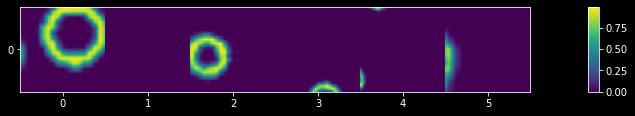

In [ ]:
imshow(source["source"], colorbar=True, bind_vminmax_01=False, unset_vminmax=True)

In [ ]:
# del ca

In [ ]:
ca = ActiveModelClass()
# ca_metrics = appenDict()
ca.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    # loss="mse",
    # metrics=["mse", "mae", "acc"]
)

In [ ]:
center_slice = np.s_[:, FINAL_PATCHSIZE//2, FINAL_PATCHSIZE//2, :]
source_packed, source_channels_keys = source.repack()
source_packed = source_packed[0:1]
print(source_channels_keys)
with tf.GradientTape() as g:
    g.watch(source_packed)
    resource = ChannelDict.resplit(source_packed, source_channels_keys)
    yhat = ca(resource)
    yhat_central = yhat[center_slice]
    dyc_dx = g.gradient(yhat_central, source_packed)
dyc_dx.shape

OrderedDict([('source', 1), ('operation', 1), ('XY', 2)])


TensorShape([1, 64, 64, 4])

In [ ]:
dyc_dpix = tf.reduce_sum(tf.math.abs(dyc_dx[0]), axis=-1)

In [ ]:
tf.reduce_max(dyc_dpix)

<tf.Tensor: shape=(), dtype=float32, numpy=0.29030165>

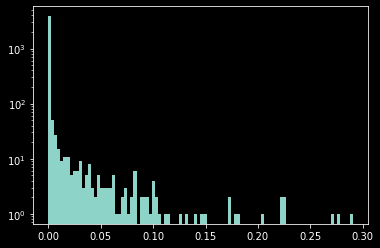

In [ ]:
_ = plt.hist(tf.reshape(dyc_dpix, [-1]), bins=100, log=True)

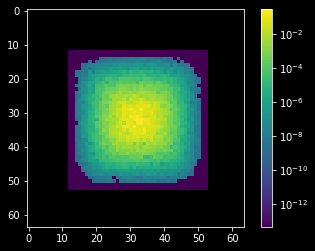

In [ ]:
plt.imshow(dyc_dpix, norm=colors.LogNorm())
plt.colorbar()

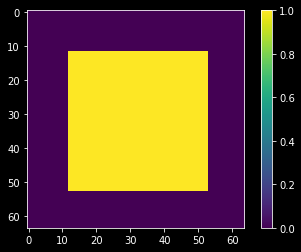

In [ ]:
plt.imshow(dyc_dpix != 0)
plt.colorbar()

In [ ]:
# print(yhat.shape)
# print(tf.reduce_mean(yhat))
# ca.summary()
# # print(ca.attention_layer.get_config())
# imshow(yhat, colorbar=True, bind_vminmax_01=False)

In [ ]:
ca.dmodel.summary()

Model: "CA_Sequential_Conv2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (1, 68, 68, 256)          905728    
                                                                 
 conv2d_7 (Conv2D)           (1, 68, 68, 256)          65792     
                                                                 
 conv2d_8 (Conv2D)           (1, 68, 68, 129)          33153     
                                                                 
Total params: 1,004,673
Trainable params: 1,004,673
Non-trainable params: 0
_________________________________________________________________


# Training and Visualization

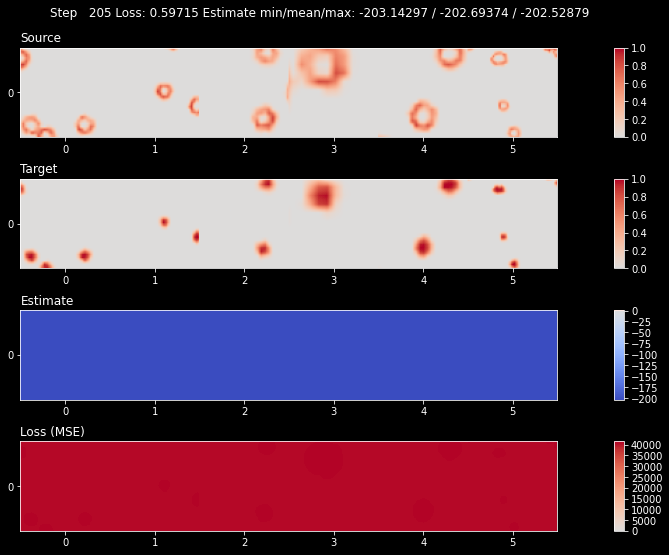

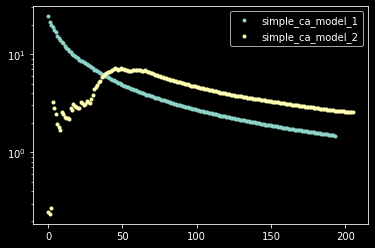

Source Shape: ({(6, 64, 64, None)}, 4)
Target Shape: (6, 64, 64, 1)
Mean Loss Shape: ()
Cell Loss Shape: (6, 64, 64)
Y-Hat Shape    : (6, 64, 64, 1)


KeyboardInterrupt: ignored

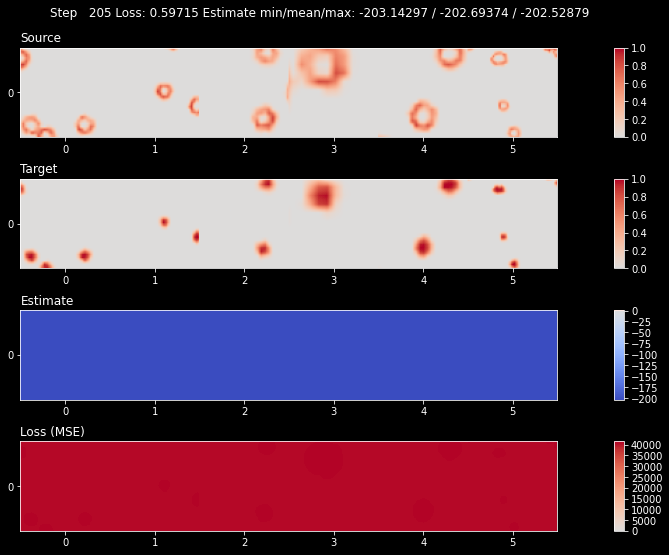

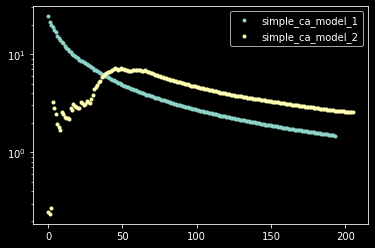

In [ ]:
##@title TV Loop
# tf.debugging.set_log_device_placement(False)
i = 0;
im_fig, im_axes = plt.subplots(4, 2, 
                                # squeeze=False, 
                                # sharex='col', 
                                linewidth=5,edgecolor="black",
                                # figsize=(FINAL_BATCHSIZE*2, 4*2), 
                                figsize=(FINAL_BATCHSIZE*(FIG_SCALE+COLORBAR_FRACTION), 4*FIG_SCALE + 1.6), 
                                constrained_layout=True, 
                                subplot_kw={},
                                gridspec_kw={"width_ratios": [FINAL_BATCHSIZE, 0.1]}
                               )

im_axes[0, 0].get_shared_x_axes().join(*im_axes[:, 0])

err_fig = plt.figure()
err_ax = err_fig.add_subplot(label="Loss")

for i in range(1000+1):
  try:
    x0 = data_iter.get_next()
  except tf.errors.OutOfRangeError:
    print("OORE")
    x0 = data_iter.get_next()
  
  source, target = split_data_to_x_y(x0)
  # print(source.shape)
  metrics = ca.train_step((source, target))
  ca_metrics.setdefault(ca.name, appenDict()).update(metrics)

  if i % 5 == 0:

    # Evaluate the model on (source, target) returning (loss, cell_loss, yhat)
    yhat = ca(source)
    cell_mse = ca.per_cell_mse(target, yhat)
    loss = ca.compute_loss(source, target, yhat)

    clear_output(wait=True)
    im_fig.suptitle(f"Step {i:5} Loss: {loss.numpy():2.5f} Estimate min/mean/max: {tf.reduce_min(yhat).numpy():2.5f} / {tf.reduce_mean(yhat).numpy():2.5f} / {tf.reduce_max(yhat).numpy():2.5f}")
    
    imshow(source.partialpack(unordered_keys="source"),ax=im_axes[0], title="Source",   colorbar=True, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=-1e-4, vcenter=0, vmax=1), unset_vminmax=True)
    imshow(target,                                     ax=im_axes[1], title="Target",   colorbar=True, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=-1e-4, vcenter=0, vmax=1), unset_vminmax=True)
    imshow(yhat,                                       ax=im_axes[2], title="Estimate", colorbar=True, cmap="coolwarm", norm=colors.TwoSlopeNorm(vcenter=0))
    imshow(cell_mse,                                   ax=im_axes[3], title="Loss (MSE)",     colorbar=True, cmap="coolwarm", norm=colors.TwoSlopeNorm(vcenter=0))

    
    err_ax.clear()
    for run_name, run_metrics in ca_metrics.items():
      err_ax.plot(run_metrics["loss"], '.', label=run_name, alpha=1)
    err_ax.set_yscale('log')
    err_ax.legend()
    display(im_fig)
    display(err_fig)

    print(f"Source Shape: {source.shapes()}")
    print(f"Target Shape: {target.shape}")
    print(f"Mean Loss Shape: {loss.shape}")
    print(f"Cell Loss Shape: {cell_mse.shape}")
    print(f"Y-Hat Shape    : {yhat.shape}")